In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from soilgen_ai.logging_config import setup_logging
import pyarrow.parquet as pq
from soilgen_ai.tts_profiles.check import TTSProfileProcessor

from soilgen_ai.vs_profiles.vs_calculation import (
    compute_vs_at_depth,
    compute_vs30,
    compute_tts,
)

from pathlib import Path

# Setup logging and seaborn
logger = setup_logging()
sns.set_palette("colorblind")
np.random.seed(42)

In [3]:
# Load the data
project_root = Path.cwd().parent.parent
file_path = project_root / "data" / "vspdb_vs_profiles.parquet"
table = pq.read_table(file_path)
df = table.to_pandas()
logger.info(f"Data loaded with shape: {df.shape}")

2025-10-23 19:23:45,475 - soilgen_ai.logging_config - INFO - Data loaded with shape: (354220, 3)


In [4]:
# Convert data
profiles_dict = {
    metadata_id: group.sort_values("depth")
    .drop(columns=["velocity_metadata_id"])
    .reset_index(drop=True)
    for metadata_id, group in df.groupby("velocity_metadata_id")
}

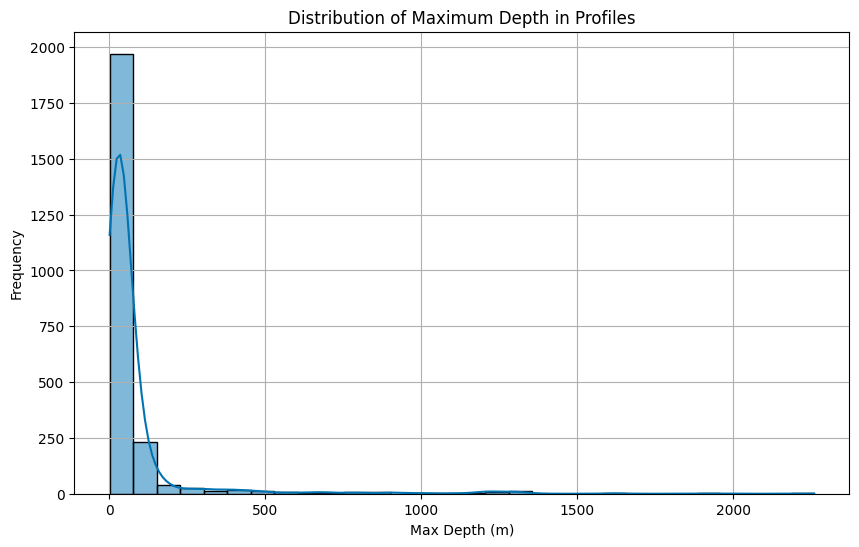

In [5]:
## Distribution of max depth in each profile
max_depths = [profile["depth"].max() for profile in profiles_dict.values()]
plt.figure(figsize=(10, 6))
sns.histplot(max_depths, bins=30, kde=True)
plt.title("Distribution of Maximum Depth in Profiles")
plt.xlabel("Max Depth (m)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [6]:
vs30 = [compute_vs30(profile) for profile in profiles_dict.values()]

2025-10-23 19:23:50,369 - soilgen_ai.logging_config - INFO - Vs30 Statistics: Mean=401.54, Median=320.04, Std=280.32
2025-10-23 19:23:50,371 - soilgen_ai.logging_config - INFO - Vs30 Min=30.48, Max=2830.07


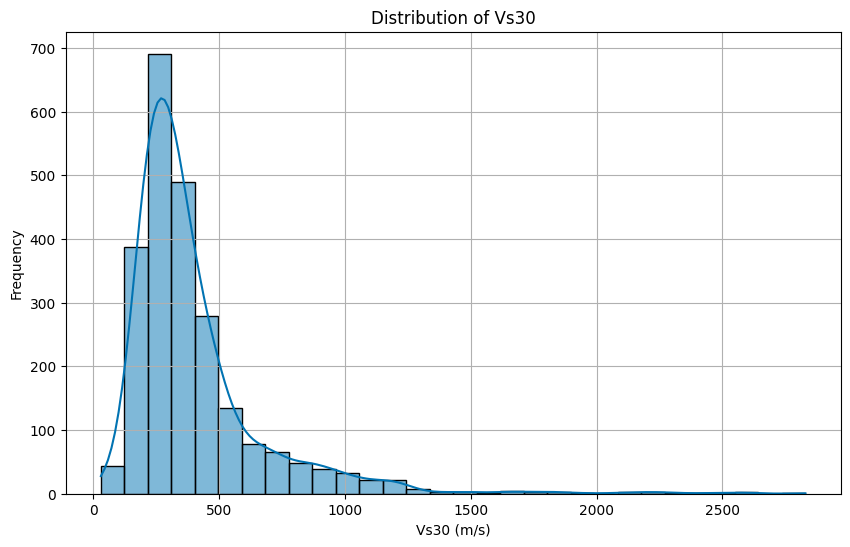

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(vs30, bins=30, kde=True)
plt.title("Distribution of Vs30")
plt.xlabel("Vs30 (m/s)")
plt.ylabel("Frequency")
plt.grid()

# Print statistics of Vs30
vs30_array = np.array(vs30)
logger.info(
    f"Vs30 Statistics: Mean={np.nanmean(vs30_array):.2f}, Median={np.nanmedian(vs30_array):.2f}, Std={np.nanstd(vs30_array):.2f}"
)
logger.info(f"Vs30 Min={np.nanmin(vs30_array):.2f}, Max={np.nanmax(vs30_array):.2f}")

In [8]:
vs_1km = [compute_vs_at_depth(profile, 1000) for profile in profiles_dict.values()]
vs_2km = [compute_vs_at_depth(profile, 2000) for profile in profiles_dict.values()]

In [9]:
len(vs_1km), len(vs_2km), len(vs30), len(profiles_dict)

(2369, 2369, 2369, 2369)

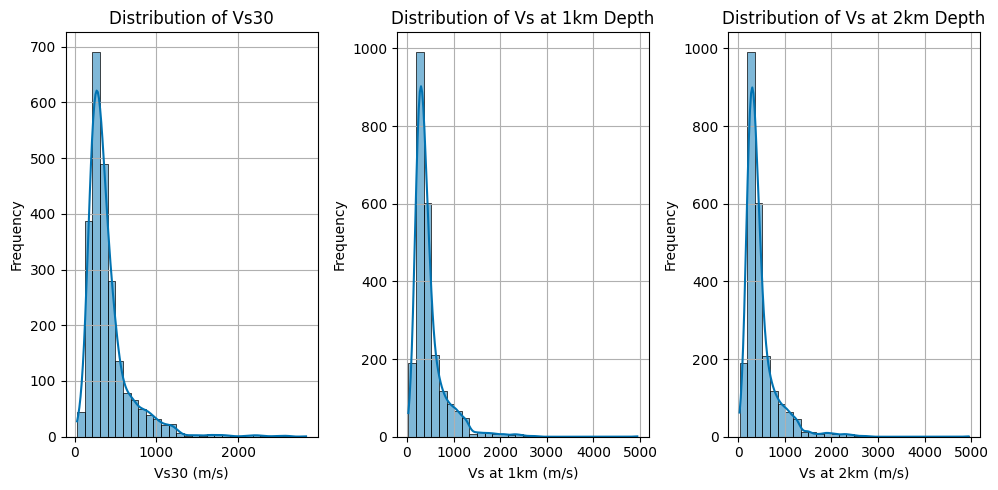

In [10]:
# Do three subfigures for each vs_depth we computed
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.histplot(vs30, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Vs30")
axes[0].set_xlabel("Vs30 (m/s)")
axes[0].set_ylabel("Frequency")
axes[0].grid()
sns.histplot(vs_1km, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Vs at 1km Depth")
axes[1].set_xlabel("Vs at 1km (m/s)")
axes[1].set_ylabel("Frequency")
axes[1].grid()
sns.histplot(vs_2km, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Vs at 2km Depth")
axes[2].set_xlabel("Vs at 2km (m/s)")
axes[2].set_ylabel("Frequency")
axes[2].grid()
plt.tight_layout()
plt.show()

In [11]:
# Try
tts_profiles = {
    metadata_id: compute_tts(profile)
    for metadata_id, profile in profiles_dict.items()
    if profile is not None
}

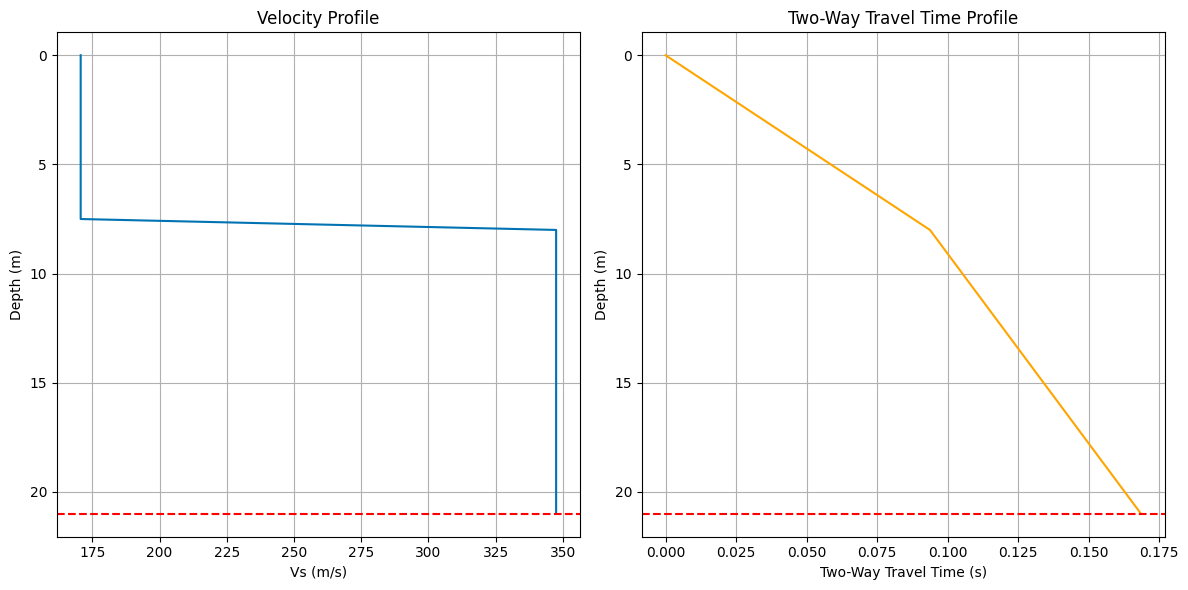

In [ ]:
# Select a random profile that has a valid (non-None) TTS profile as well.
valid_keys = [
    k for k in profiles_dict.keys() if k in tts_profiles and tts_profiles[k] is not None
]
if len(valid_keys) == 0:
    raise RuntimeError("No valid profiles with computed TTS available for plotting.")

idx = np.random.choice(valid_keys, size=1, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
profile_vs = profiles_dict[idx[0]]
profile_tts = tts_profiles.get(idx[0])

# Velocity profile
ax[0].plot(profile_vs["vs_value"], profile_vs["depth"])
ax[0].axhline(profile_vs["depth"].max(), color="red", linestyle="--", label="Max Depth")
ax[0].set_title("Velocity Profile")
ax[0].set_xlabel("Vs (m/s)")
ax[0].set_ylabel("Depth (m)")
ax[0].invert_yaxis()
ax[0].grid()

# TTS profile (guard against None)
if profile_tts is not None:
    ax[1].plot(profile_tts["tts"], profile_tts["depth"], color="orange")
    ax[1].axhline(
        profile_tts["depth"].max(), color="red", linestyle="--", label="Max Depth"
    )
else:
    ax[1].text(0.5, 0.5, "No TTS profile available", ha="center", va="center")

ax[1].set_title("Two-Way Travel Time Profile")
ax[1].set_xlabel("Two-Way Travel Time (s)")
ax[1].set_ylabel("Depth (m)")
ax[1].invert_yaxis()
ax[1].grid()

plt.tight_layout()
plt.show()

In [13]:
def count_num_layers(profile, threshold=10):
    """Count the number of layers in a profile based on a velocity change threshold."""
    velocities = profile["vs_value"].values
    changes = np.abs(np.diff(velocities))
    num_layers = np.sum(changes > threshold) + 1  # +1 for the first layer
    return num_layers

In [14]:
real_layers = np.array([count_num_layers(profile) for profile in tts_profiles.values()])

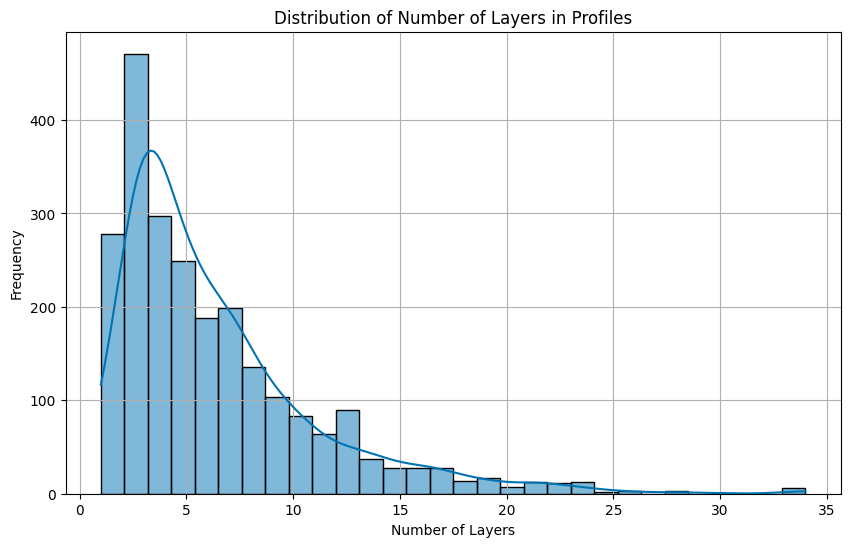

In [15]:
# Plot distribution of number of layers
plt.figure(figsize=(10, 6))
sns.histplot(real_layers, bins=30, kde=True)
plt.title("Distribution of Number of Layers in Profiles")
plt.xlabel("Number of Layers")
plt.ylabel("Frequency")
plt.grid()
plt.show()

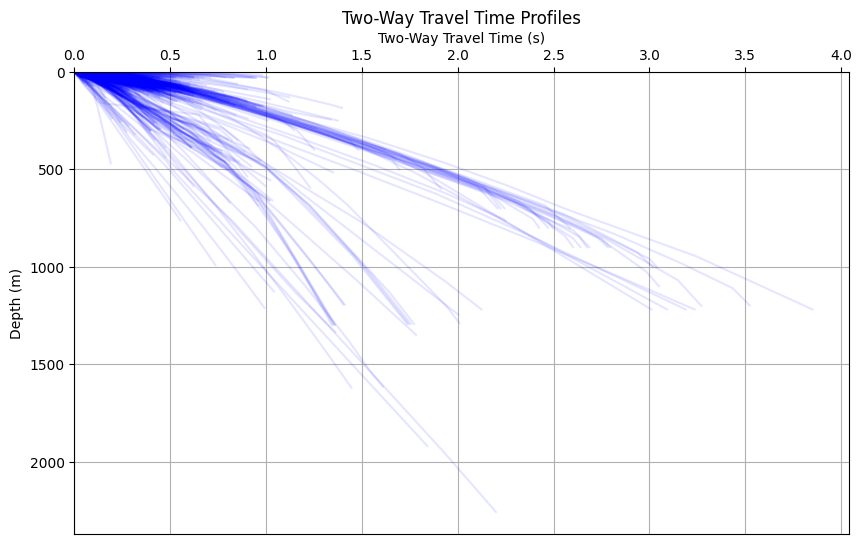

In [16]:
# Plot all the tts profiles in three subplots, one with normal units, then yscale log, then xscale log, and both log
plt.figure(figsize=(10, 6))
for profile in tts_profiles.values():
    plt.plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

plt.title("Two-Way Travel Time Profiles")
plt.xlabel("Two-Way Travel Time (s)")
plt.ylabel("Depth (m)")
# Xlabel and ticks on top
plt.gca().xaxis.set_label_position("top")
plt.gca().xaxis.tick_top()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

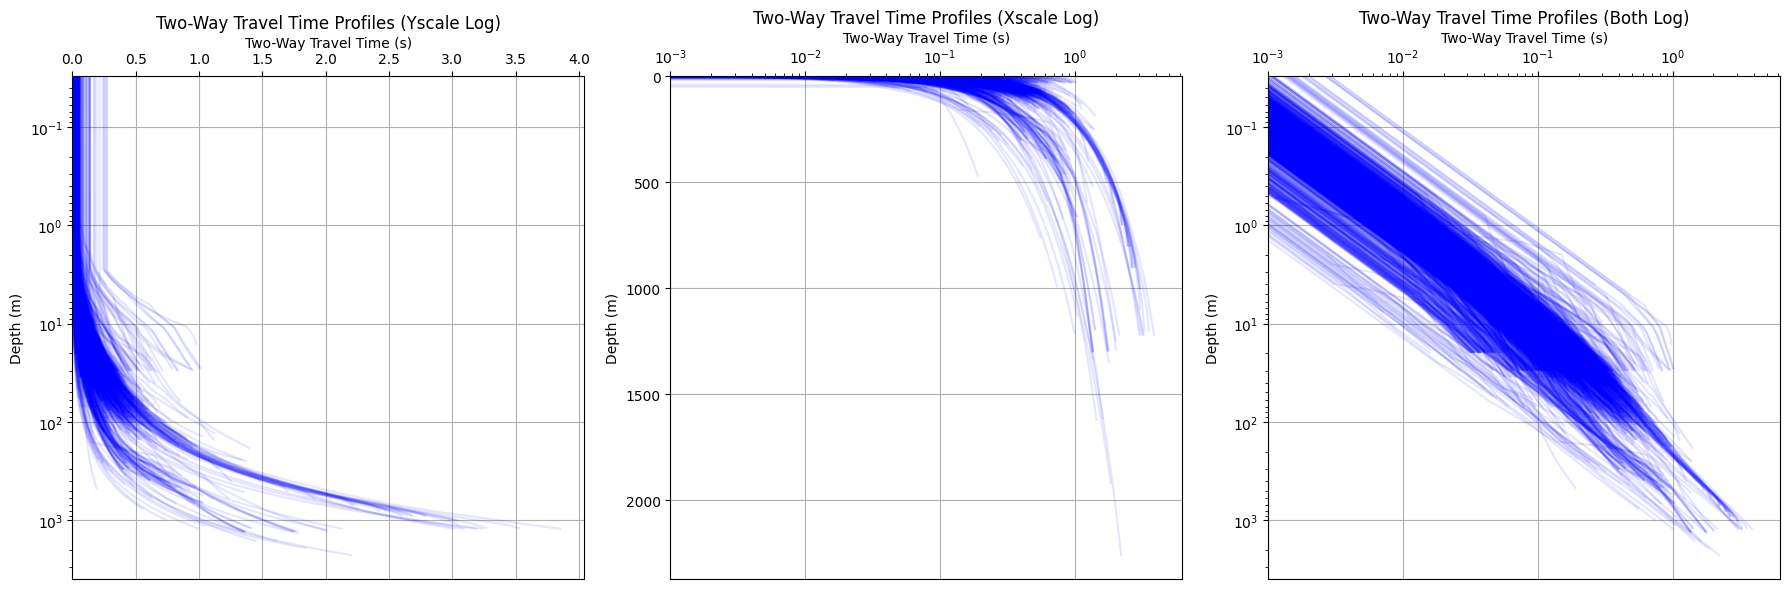

In [17]:
# Plot all the tts profiles in three subplots, one with yscale log, then xscale log, and both log
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for profile in tts_profiles.values():
    ax[0].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[1].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[2].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

ax[0].set_title("Two-Way Travel Time Profiles (Yscale Log)")
ax[0].set_yscale("log")
ax[1].set_title("Two-Way Travel Time Profiles (Xscale Log)")
ax[1].set_xscale("log")
ax[2].set_title("Two-Way Travel Time Profiles (Both Log)")
ax[2].set_xscale("log")
ax[2].set_yscale("log")

# Use a small positive value for log scales
min_tts = min(
    [
        profile["tts"][profile["tts"] > 0].min()
        for profile in tts_profiles.values()
        if profile is not None
    ]
)
min_depth = min(
    [
        profile["depth"][profile["depth"] > 0].min()
        for profile in tts_profiles.values()
        if profile is not None
    ]
)
eps = 1e-3
x_min = max(min_tts, eps)
y_min = max(min_depth, eps)


ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=y_min)
ax[1].set_xlim(left=x_min)
ax[1].set_ylim(bottom=0)
ax[2].set_xlim(left=x_min)
ax[2].set_ylim(bottom=y_min)
# Xlabel and ticks on top
for a in ax:
    a.set_xlabel("Two-Way Travel Time (s)")
    a.set_ylabel("Depth (m)")
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid()
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()


plt.tight_layout()
plt.show()

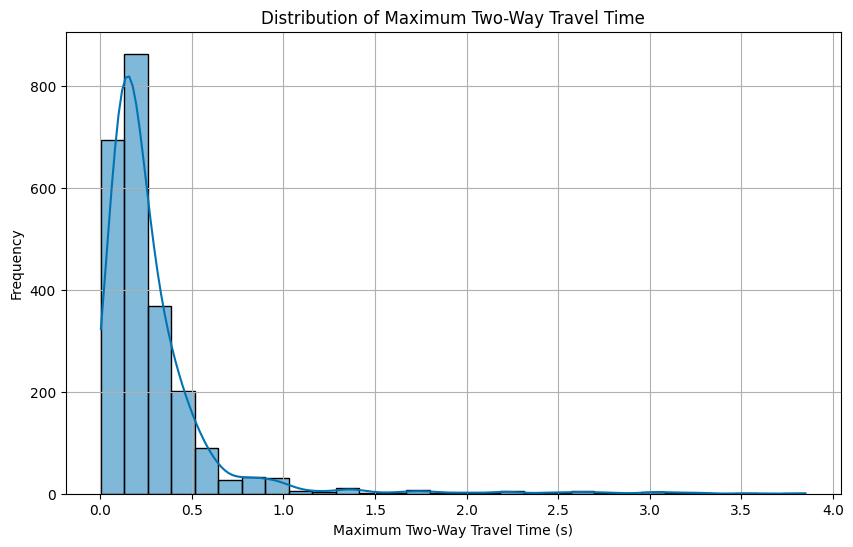

In [18]:
# Statistics on tts

## Distribution of max tts in each profile
max_tts = [
    profile["tts"].max() for profile in tts_profiles.values() if profile is not None
]
plt.figure(figsize=(10, 6))
sns.histplot(max_tts, bins=30, kde=True)
plt.title("Distribution of Maximum Two-Way Travel Time")
plt.xlabel("Maximum Two-Way Travel Time (s)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

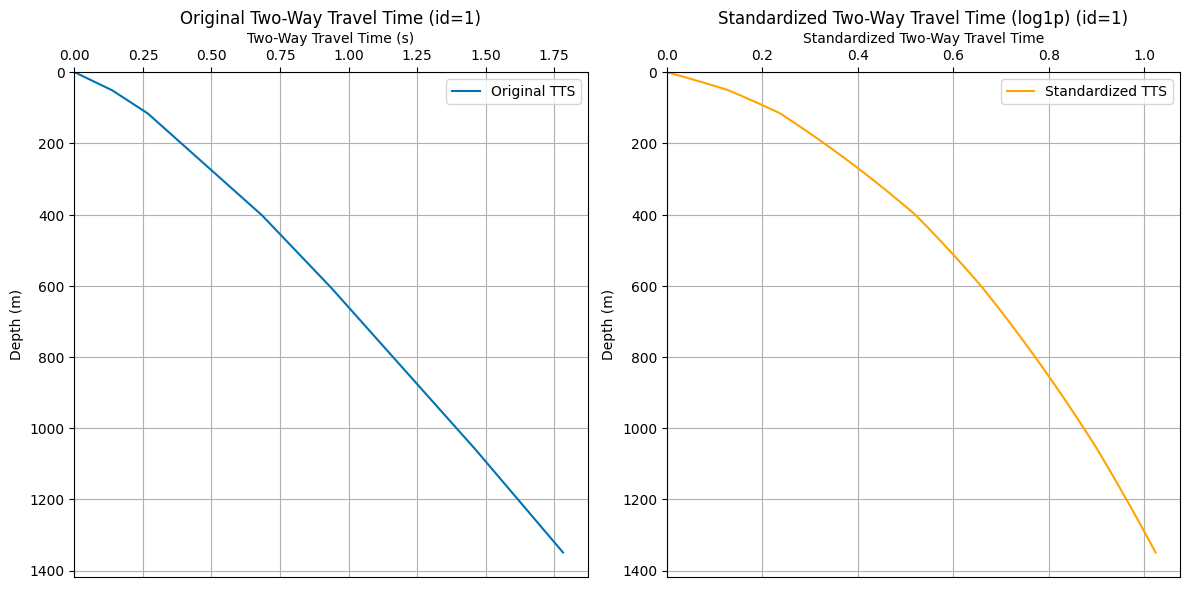

In [ ]:
# Understanding the standarization we are doing with log1p

standardized_tts = {
    metadata_id: pd.DataFrame(
        {
            "depth": profile["depth"],
            "vs_value": profile["vs_value"],
            "tts": np.log1p(profile["tts"]),
        }
    )
    for metadata_id, profile in tts_profiles.items()
    if profile is not None
}

# Pick a valid key that has a non-empty TTS profile to avoid "None is not subscriptable"
valid_keys = [
    k
    for k, v in tts_profiles.items()
    if v is not None and not v.empty and "tts" in v.columns and "depth" in v.columns
]
if not valid_keys:
    raise RuntimeError("No valid TTS profiles found for plotting.")

plot_key = valid_keys[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(
    x=tts_profiles[plot_key]["tts"],  # type: ignore
    y=tts_profiles[plot_key]["depth"],  # type: ignore
    label="Original TTS",
    ax=ax[0],
)
sns.lineplot(
    x=standardized_tts[plot_key]["tts"],
    y=standardized_tts[plot_key]["depth"],
    label="Standardized TTS",
    color="orange",
    ax=ax[1],
)

# Set titles and labels
ax[0].set_title(f"Original Two-Way Travel Time (id={plot_key})")
ax[0].set_xlabel("Two-Way Travel Time (s)")
ax[0].set_ylabel("Depth (m)")
ax[1].set_title(f"Standardized Two-Way Travel Time (log1p) (id={plot_key})")
ax[1].set_xlabel("Standardized Two-Way Travel Time")
ax[1].set_ylabel("Depth (m)")

# Consistent axis formatting and grid
for a in ax:
    a.set_xlim(left=0)
    a.set_ylim(bottom=0)
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid(True)
    a.invert_yaxis()

plt.tight_layout()
plt.show()

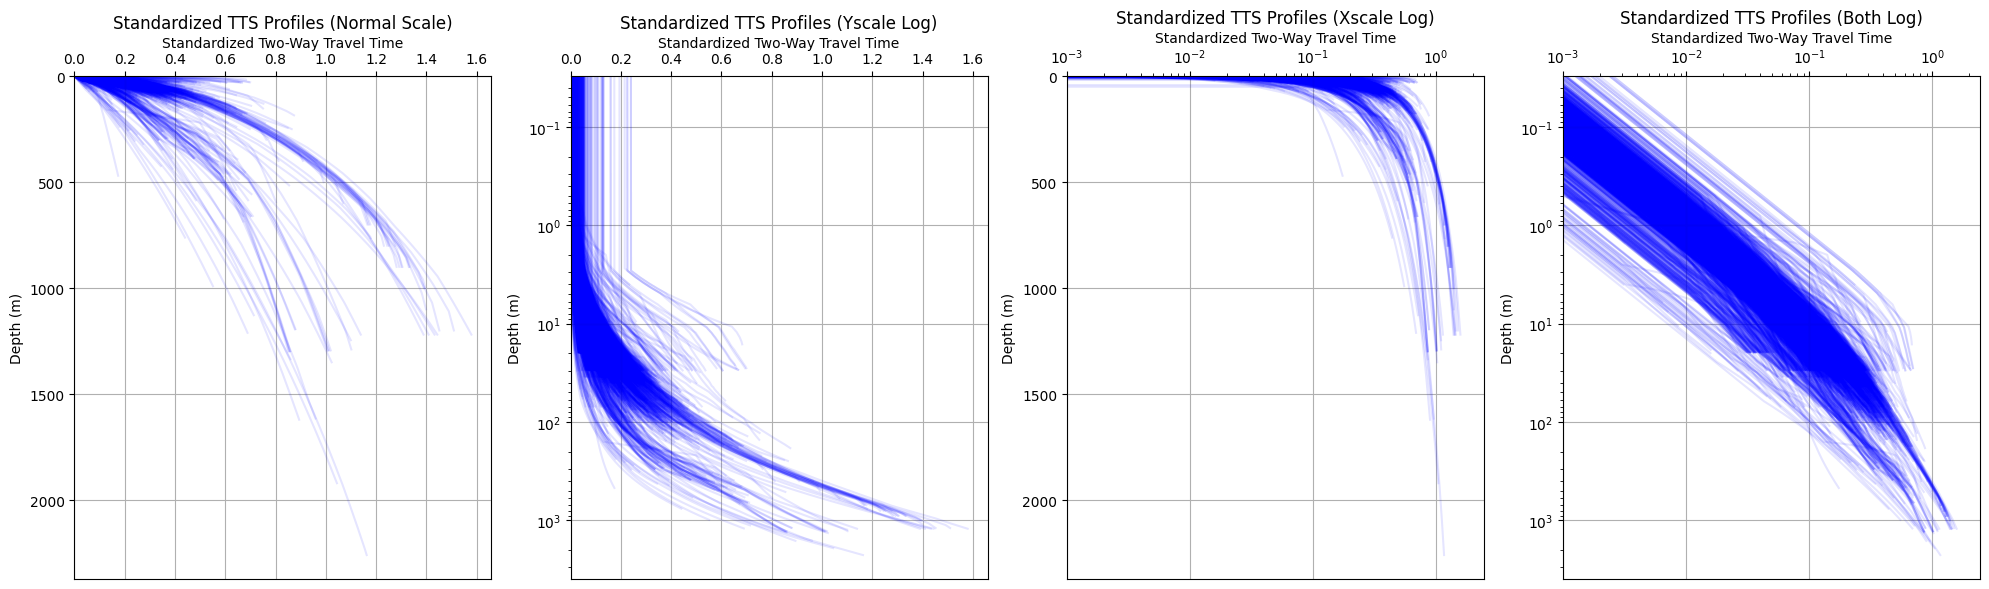

In [28]:
# Plot all the standardized tts profiles in four subplots, one with normal units, then yscale log, then xscale log, and both log
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for profile in standardized_tts.values():
    ax[0].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[1].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[2].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[3].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

ax[0].set_title("Standardized TTS Profiles (Normal Scale)")
ax[1].set_title("Standardized TTS Profiles (Yscale Log)")
ax[1].set_yscale("log")
ax[2].set_title("Standardized TTS Profiles (Xscale Log)")
ax[2].set_xscale("log")
ax[3].set_title("Standardized TTS Profiles (Both Log)")
ax[3].set_xscale("log")
ax[3].set_yscale("log")
# Use a small positive value for log scales
min_tts = min(
    [profile["tts"][profile["tts"] > 0].min() for profile in standardized_tts.values()]
)
min_depth = min(
    [
        profile["depth"][profile["depth"] > 0].min()
        for profile in standardized_tts.values()
    ]
)
eps = 1e-3
x_min = max(min_tts, eps)
y_min = max(min_depth, eps)

ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=0)
ax[1].set_xlim(left=0)
ax[1].set_ylim(bottom=y_min)
ax[2].set_xlim(left=x_min)
ax[2].set_ylim(bottom=0)
ax[3].set_xlim(left=x_min)
ax[3].set_ylim(bottom=y_min)
# Xlabel and ticks on top
for a in ax:
    a.set_xlabel("Standardized Two-Way Travel Time")
    a.set_ylabel("Depth (m)")
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid()
    a.invert_yaxis()

plt.tight_layout()
plt.show()

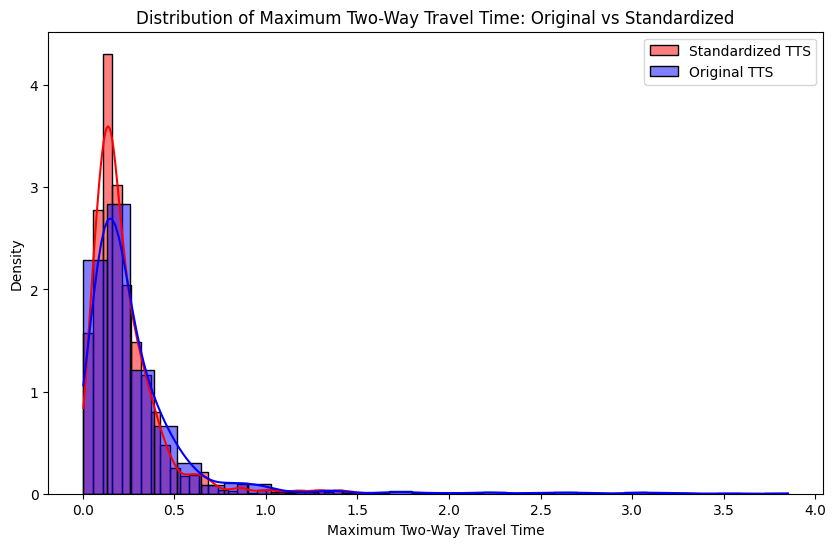

In [ ]:
## Distribution of max standardized tts in each profile compared with max original tts
max_standardized_tts = [df["tts"].max() for df in standardized_tts.values()]
max_standardized_tts = [df["tts"].max() for df in standardized_tts.values()]
max_original_tts = [profile["tts"].max() for profile in tts_profiles.values()]  # type: ignore

plt.figure(figsize=(10, 6))
sns.histplot(
    max_standardized_tts,
    bins=30,
    kde=True,
    color="red",
    label="Standardized TTS",
    stat="density",
)
sns.histplot(
    max_original_tts,
    bins=30,
    kde=True,
    color="blue",
    label="Original TTS",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Maximum Two-Way Travel Time: Original vs Standardized")
plt.xlabel("Maximum Two-Way Travel Time")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
# Compute the spectral ttf vs freq (like if we assumes depth is the same as time (?)) [Experiment]

from scipy.fft import rfft, rfftfreq
from typing import Optional


def compute_spectral_tts(
    profile: pd.DataFrame, num_samples: Optional[int] = None
) -> pd.DataFrame:
    """
    Computes the spectral representation of the Two-Way Travel Time (TTS) profile.

    If the depth is not uniformly spaced, it resamples the profile to
    a uniform grid before applying the FFT.

    Args:
        profile (pd.DataFrame): DataFrame with 'depth' and 'tts' columns.
        num_samples (int, optional): The number of samples for resampling.
                                     Defaults to the original number of samples.

    Returns:
        pd.DataFrame: DataFrame with 'freq' and 'spectral_tts'.
    """
    if num_samples is None:
        num_samples = len(profile)

    # Ensure we operate on plain numpy arrays (avoid pandas ExtensionArray type)
    depth = profile["depth"].to_numpy(dtype=float)
    tts = profile["tts"].to_numpy(dtype=float)

    # Handle very short profiles
    if len(depth) < 2:
        depth_spacing = 1.0
        spectral_tts = np.abs(rfft(tts))  # type: ignore
        freq = rfftfreq(len(tts), d=depth_spacing)
        return pd.DataFrame({"freq": freq, "spectral_tts": spectral_tts})

    # Check for uniform spacing safely
    diffs = np.diff(depth)
    is_uniform = True if diffs.size == 0 else np.allclose(diffs, diffs[0])

    if not is_uniform:
        # Resample to a uniform grid if not uniformly spaced
        uniform_depth = np.linspace(depth.min(), depth.max(), num=num_samples)
        tts = np.interp(uniform_depth, depth, tts)
        depth_spacing = uniform_depth[1] - uniform_depth[0] if num_samples > 1 else 1.0
    else:
        depth_spacing = diffs[0] if diffs.size > 0 else 1.0

    # Compute FFT
    spectral_tts = np.abs(rfft(tts))  # type: ignore
    freq = rfftfreq(len(tts), d=depth_spacing)

    # The length of rfft output is n//2 + 1
    return pd.DataFrame({"freq": freq, "spectral_tts": spectral_tts})


freq_tts = {
    metadata_id: compute_spectral_tts(profile)
    for metadata_id, profile in tts_profiles.items()
    if profile is not None and not profile.empty
}

Text(0, 0.5, 'Spectral Amplitude')

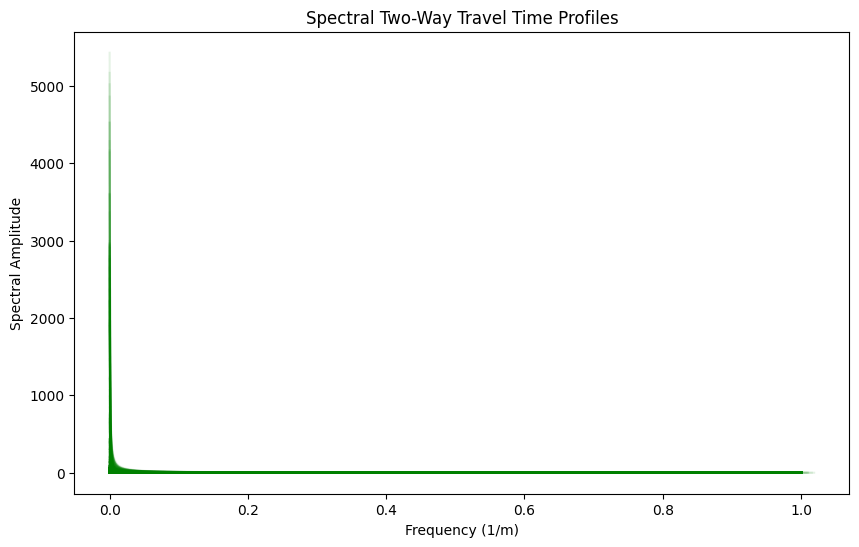

In [31]:
plt.figure(figsize=(10, 6))
for profile in freq_tts.values():
    plt.plot(profile["freq"], profile["spectral_tts"], alpha=0.1, color="green")

plt.title("Spectral Two-Way Travel Time Profiles")
plt.xlabel("Frequency (1/m)")
plt.ylabel("Spectral Amplitude")

In [32]:
processor = TTSProfileProcessor(tts_profiles)
processor.process_profiles()
processor.generate_report()

2025-10-23 19:28:12,194 - soilgen_ai.logging_config - INFO - --- Starting Enhanced TTS Profile Processing ---
2025-10-23 19:28:16,625 - soilgen_ai.logging_config - INFO - Processing complete.
2025-10-23 19:28:16,626 - soilgen_ai.logging_config - INFO - 
--- TTS Profile Validation Report ---
2025-10-23 19:28:16,627 - soilgen_ai.logging_config - INFO - Total Profiles Processed: 2369
2025-10-23 19:28:16,627 - soilgen_ai.logging_config - INFO - ✅ Valid Profiles: 2369
2025-10-23 19:28:16,628 - soilgen_ai.logging_config - WARNING - ❌ Invalid Profiles: 0
2025-10-23 19:28:16,629 - soilgen_ai.logging_config - INFO - 
--- Analysis of Valid Profiles ---
2025-10-23 19:28:16,630 - soilgen_ai.logging_config - INFO - Showing example from Profile ID: 1
2025-10-23 19:28:16,738 - soilgen_ai.logging_config - INFO - 
--- Sanity Check Summary (Calculated Vs vs. Original Vs) ---
2025-10-23 19:28:16,739 - soilgen_ai.logging_config - INFO - Mean Difference: 0.00%
2025-10-23 19:28:16,743 - soilgen_ai.logging_c

       depth  vs_value       tts  calculated_vs_mps  vs_diff_percent
0        0.0     738.0  0.00e+00              738.0         0.00e+00
1        0.5     738.0  1.36e-03              738.0         0.00e+00
2        1.0     738.0  2.71e-03              738.0         3.08e-14
...      ...       ...       ...                ...              ...
2697  1348.5    1812.0  1.78e+00             1812.0        -1.06e-11
2698  1349.0    1812.0  1.78e+00             1812.0        -1.06e-11
2699  1349.5    1812.0  1.78e+00                NaN              NaN

[2700 rows x 5 columns]


In [33]:
processor = TTSProfileProcessor(standardized_tts)
processor.process_profiles()
processor.generate_report()

2025-10-23 19:28:16,790 - soilgen_ai.logging_config - INFO - --- Starting Enhanced TTS Profile Processing ---
2025-10-23 19:28:20,082 - soilgen_ai.logging_config - INFO - Processing complete.
2025-10-23 19:28:20,083 - soilgen_ai.logging_config - INFO - 
--- TTS Profile Validation Report ---
2025-10-23 19:28:20,084 - soilgen_ai.logging_config - INFO - Total Profiles Processed: 2369
2025-10-23 19:28:20,085 - soilgen_ai.logging_config - INFO - ✅ Valid Profiles: 2369
2025-10-23 19:28:20,085 - soilgen_ai.logging_config - WARNING - ❌ Invalid Profiles: 0
2025-10-23 19:28:20,086 - soilgen_ai.logging_config - INFO - 
--- Analysis of Valid Profiles ---
2025-10-23 19:28:20,087 - soilgen_ai.logging_config - INFO - Showing example from Profile ID: 1
2025-10-23 19:28:20,172 - soilgen_ai.logging_config - INFO - 
--- Sanity Check Summary (Calculated Vs vs. Original Vs) ---
2025-10-23 19:28:20,174 - soilgen_ai.logging_config - INFO - Mean Difference: 56.75%
2025-10-23 19:28:20,177 - soilgen_ai.logging_

       depth  vs_value       tts  calculated_vs_mps  vs_diff_percent
0        0.0     738.0  0.00e+00             738.50             0.07
1        0.5     738.0  1.35e-03             739.50             0.20
2        1.0     738.0  2.71e-03             740.50             0.34
...      ...       ...       ...                ...              ...
2697  1348.5    1812.0  1.02e+00            5039.91           178.14
2698  1349.0    1812.0  1.02e+00            5040.91           178.20
2699  1349.5    1812.0  1.02e+00                NaN              NaN

[2700 rows x 5 columns]


In [34]:
# Save tts profiles with calculated velocity to parquet
output_path = project_root / "data" / "vspdb_tts_profiles.parquet"
all_profiles = pd.concat(
    processor.processed_profiles.values(), keys=processor.processed_profiles.keys()
)
all_profiles.reset_index(level=0, inplace=True)
all_profiles.rename(columns={"level_0": "velocity_metadata_id"}, inplace=True)
all_profiles.to_parquet(output_path, index=False)